In [53]:
import psycopg2
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
import seaborn as sns

In [2]:
with open('handle_cid_pid_keys.txt') as f:
    keys = [l.strip().split(',') for l in f.readlines()]

In [4]:
db = 'codeforces'
usr = 'Joy'
con = psycopg2.connect(database=db, user=usr)

The idea is to split users into different groups by rating blocks

Ex. green people who never got to blue vs. green people who eventually got to blue

In [6]:
pd.read_sql("""
    SELECT * FROM probability_solve
        WHERE
            smoothed_3months 
    LIMIT 10
""", con)

,handle,contestid,problemid,solve_probability,smoothed_3months,problem_rating
0,-----,108,A,0.588290,1292.000000,1230.0
1,-----,108,A,0.999415,1292.000000,-1.0
2,-----,118,A,0.908455,1233.666667,835.0
3,-----,118,B,0.539732,1233.666667,1206.0
4,-----,118,A,0.812445,1233.666667,979.0
5,-----,118,B,0.405682,1233.666667,1300.0
6,-----,118,A,0.495203,1233.666667,1237.0
7,-----,114,B,0.132338,1271.333333,1598.0
8,-----,118,C,0.219541,1233.666667,1454.0
9,-----,118,C,0.007732,1233.666667,2077.0


# People who improved vs those who didn't

In [120]:
cutoffs = { 
        'gray'      : [0, 1199],
        'green'     : [1200, 1399],
        'teal'      : [1400, 1599],
        'lowblue'   : [1600, 1799],
        'blue'      : [1700, 1899],
        'lowpurple' : [1900, 2099],
        'purple'    : [2000, 2199],
        'yellow'    : [2200, 2399],
        'red'       : [2400, 5000]
        }

In [146]:
lo = 0
hi = 1000
handlecolorgroups = {}
#for k, v in cutoffs.iteritems():
handlecolorgroups[k] = pd.read_sql("""
SELECT * FROM
    (
        SELECT handle, COUNT(*) FROM user_rating_smooth
            WHERE
                smoothed_3months >= %d
                AND
                smoothed_3months <= %d
        GROUP BY handle
        HAVING COUNT(*) >= 5
    ) as a
    INNER JOIN
    (
        SELECT handle, COUNT(*) FROM user_rating_smooth
            WHERE
                smoothed_3months >= %d
                AND
                smoothed_3months <= %d
        GROUP BY handle
        HAVING COUNT(*) >= 5
    ) as b;

""" % (lo, hi), con)


ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



TypeError: not enough arguments for format string

In [122]:
gray = set(handlecolorgroups['gray'].handle)
green = set(handlecolorgroups['green'].handle)
teal = set(handlecolorgroups['teal'].handle)
lowblue = set(handlecolorgroups['lowblue'].handle)
blue = set(handlecolorgroups['blue'].handle)
lowpurple = set(handlecolorgroups['lowpurple'].handle)
purple = set(handlecolorgroups['purple'].handle)
yellow = set(handlecolorgroups['yellow'].handle)
red = set(handlecolorgroups['red'].handle)

In [123]:
gray_imp = gray.intersection(green)
green_imp = green.intersection(teal)
teal_imp = teal.intersection(blue)
blue_imp = blue.intersection(purple)
lowblue_imp = blue.intersection(purple)
lowpurple_imp = lowpurple.intersection(yellow)
purple_imp = purple.intersection(yellow)
yellow_imp = yellow.intersection(red)

In [126]:
gray_non = gray.difference(gray_imp)
green_non = green.difference(green_imp)
teal_non = teal.difference(teal_imp)
lowblue_non = lowblue.difference(lowblue_imp)
blue_non = blue.difference(blue_imp)
lowpurple_non = lowpurple.difference(lowpurple_imp)
purple_non = purple.difference(purple_imp)
yellow_non = yellow.difference(yellow_imp)

In [127]:
non = [(len(gray_non) + 0.0) / len(gray),
       (len(green_non) + 0.0) / len(green),
       (len(teal_non) + 0.0) / len(teal),
       (len(lowblue_non) + 0.0) / len(lowblue),
       (len(blue_non) + 0.0) / len(blue),
       (len(lowpurple_non) + 0.0) / len(lowpurple),
       (len(purple_non) + 0.0) / len(purple),
       (len(yellow_non) + 0.0) / len(yellow)
      ]

imp = [(len(gray_imp) + 0.0) / len(gray),
       (len(green_imp) + 0.0) / len(green),
       (len(teal_imp) + 0.0) / len(teal),
       (len(lowblue_imp) + 0.0) / len(lowblue),
       (len(blue_imp) + 0.0) / len(blue),
       (len(lowpurple_imp) + 0.0) / len(lowpurple),
       (len(purple_imp) + 0.0) / len(purple),
       (len(yellow_imp) + 0.0) / len(yellow)
      ]


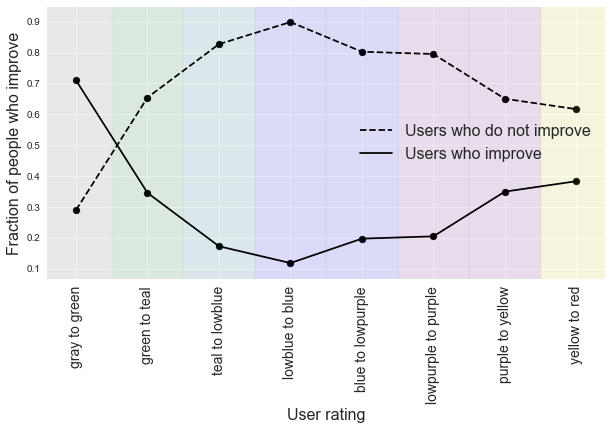

In [130]:
colors = { 
        'gray'  : 'gray',
        'green' : 'green',                                                                                                            
        'teal'  : 'teal',
        'blue'  : 'blue',
        'purple': 'purple',
        'yellow': 'yellow',
        'red'   : 'red'
        }


plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.plot(non, ls="--", c="0")
plt.scatter(range(len(non)), non, c='0')
plt.plot(imp, c='0')
plt.scatter(range(len(imp)), imp, c='0')
plt.ylabel("Fraction of people who improve", fontsize = 16)
plt.xlabel("User rating", fontsize = 16)
ax = plt.gca()
plt.legend(["Users who do not improve", "Users who improve"], fontsize = 16)
import matplotlib.patches as patches
ax.add_patch( patches.Rectangle( (-.5, 0), 1, 2, alpha=0.1, color=colors['gray']) )
ax.add_patch( patches.Rectangle( (.5, 0), 1, 2, alpha=0.1, color=colors['green']) )
ax.add_patch( patches.Rectangle( (1.5, 0), 1, 2, alpha=0.1, color=colors['teal']) )
ax.add_patch( patches.Rectangle( (2.5, 0), 1, 2, alpha=0.1, color=colors['blue']) )
ax.add_patch( patches.Rectangle( (3.5, 0), 1, 2, alpha=0.1, color=colors['blue']) )
ax.add_patch( patches.Rectangle( (4.5, 0), 1, 2, alpha=0.1, color=colors['purple']) )
ax.add_patch( patches.Rectangle( (5.5, 0), 1, 2, alpha=0.1, color=colors['purple']) )
ax.add_patch( patches.Rectangle( (6.5, 0), 1, 2, alpha=0.1, color=colors['yellow']) )

x = range(len(non))
labels=['gray to green',
        'green to teal',
        'teal to lowblue',
        'lowblue to blue',
        'blue to lowpurple',
        'lowpurple to purple',
        'purple to yellow',
        'yellow to red']
plt.xticks(x, labels, rotation='vertical', fontsize=14)

#ax.patch.set_facecolor('white')
ax.patch.set_alpha(.5)

In [47]:
df.smoothed_3months

,CHALLENGED,COMPILATION_ERROR,CONTESTANT,GNU C++,IDLENESS_LIMIT_EXCEEDED,MS C++,OK,PRACTICE,TIME_LIMIT_EXCEEDED,VIRTUAL,...,Perl,Pike,Java 8 ZIP,D,Ocaml,PyPy 3,Mono C#,Java 7,rating_diff,solve_probability
0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-62.000000,0.588290
1,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1293.000000,0.999415
2,NaN,1.0,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-398.666667,0.908455
3,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-27.666667,0.539732
4,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-254.666667,0.812445


In [134]:
query = """
SELECT handle, count(*) FROM probability_solve
    WHERE
        smoothed_3months >= %d
        AND
        smoothed_3months <= %d
    GROUP BY handle
""" % (1500, 1600)
pd.read_sql(query, con)

,handle,count
0,xxyyttxx,27
1,Nightfury18,30
2,madlpx,31
3,nbonair,2
4,serlis,34
5,bshu,93
6,hdu_lgc,61
7,complex,9
8,drbitboy,16
9,vickey,34


In [46]:
from collections import defauldict

problem_solves = defaultdict[]
for h, c, p in keys:
    


IndentationError: expected an indented block (<ipython-input-46-ff8cda1adc85>, line 2)

In [232]:
import pickle
with open('ols_models_final.pickle') as f:
    m = pickle.load(f)

df_coef = m['df_coef']

In [304]:
sig_coef = df_coef[m['variables']]

In [306]:
for c in sig_coef.columns:
    print c

java
lowlevel
max_probability_contest
max_timediff
mean_probability_contest
mean_probability_practice
python
smoothed_3months
std_probability_contest
std_probability_practice
tot_solvetime
unique_tags_total
time_between_mean
time_between_std
log_max_probability_practice
log_mean_probability_practice
log_std_probability_contest
log_std_probability_practice
exp_max_probability_contest
exp_max_probability_practice
exp_mean_probability_practice
exp_performance
exp_rank
exp_std_probability_practice
tanh_java
tanh_lowlevel
tanh_max_probability_contest
tanh_max_ratingdiff_practice
tanh_max_solvetime
tanh_max_timediff
tanh_mean_ratingdiff_practice
tanh_n100
tanh_oldrating
tanh_python
tanh_smoothed_3months
tanh_std_probability_contest
tanh_std_probability_practice
tanh_std_ratingdiff_contest 
tanh_std_ratingdiff_practice
tanh_std_timediff
tanh_tot_solvetime
tanh_total_problems
tanh_unique_newtags
tanh_unique_tags_total
tanh_binary search
tanh_bitmasks
tanh_combinatorics
tanh_constructive algori

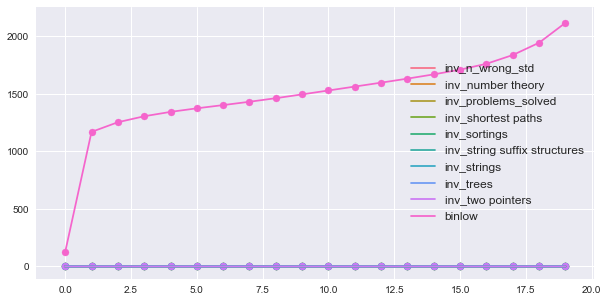

In [369]:
a = 110
b = a+10
with sns.color_palette("husl", 10):
    for i in range(a, b):
        var = sig_coef.columns[i]
        plt.plot(sig_coef[var])
        plt.scatter(range(sig_coef.shape[0]), sig_coef[var])
plt.legend(sig_coef.columns[a:b], fontsize=12)

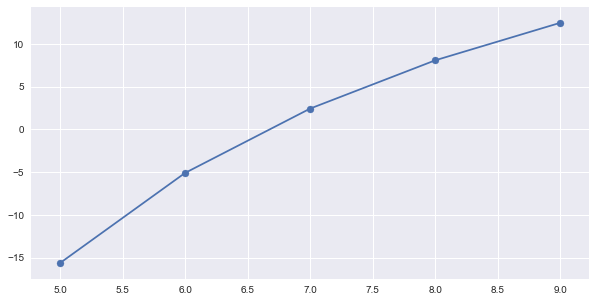

In [361]:
group = 1
x = np.arange(5, 10)
y = df_coef.tanh_n_contest[group] * np.tanh(x) + df_coef.inv_total_contests[group] * 1.0/x + df_coef.inv_n_contest[group] * 1.0/x
y *= 532.75
plt.plot(x, y)
plt.scatter(x, y)

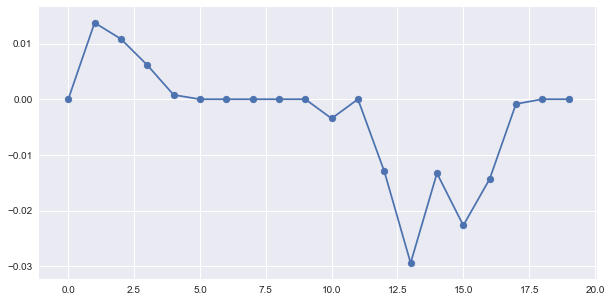

In [329]:
var = 'max_probability_contest'
plt.plot(sig_coef[var])
plt.scatter(range(sig_coef.shape[0]), sig_coef[var])

In [248]:
df_coef.head()

,java,lowlevel,max_probability_contest,max_timediff,mean_probability_contest,mean_probability_practice,python,smoothed_3months,std_probability_contest,std_probability_practice,...,inv_number theory,inv_problems_solved,inv_shortest paths,inv_sortings,inv_string suffix structures,inv_strings,inv_trees,inv_two pointers,binlow,binhigh
126,0.002338,0.003481,0.000000,-0.000000,-0.0,0.0,0.000000,0.0,0.000000,-0.0,...,0.000165,0.006420,0.001307,0.000036,-0.0,-0.000312,-0.006839,0.002257,126,1169
1169,0.000109,0.000432,0.013731,0.001923,-0.0,-0.0,0.000000,0.0,0.000000,0.0,...,0.003297,0.004447,-0.000000,-0.000500,0.0,-0.000097,0.000000,0.000000,1169,1253
1253,-0.000000,0.002269,0.010820,-0.000000,0.0,0.0,0.001769,0.0,0.000000,0.0,...,0.000090,0.001613,0.000000,0.000445,-0.0,0.000031,0.001340,0.001459,1253,1305
1305,-0.002268,0.000298,0.006134,-0.000000,0.0,0.0,0.000000,0.0,0.000202,0.0,...,-0.000000,0.002622,0.000947,-0.001084,-0.0,-0.001267,0.000000,0.000000,1305,1343
1343,0.000000,0.002450,0.000780,-0.001522,-0.0,0.0,0.003274,0.0,0.007542,-0.0,...,-0.000000,0.001082,-0.000000,0.000000,-0.0,-0.000000,0.000864,0.000000,1343,1374


In [262]:
usr_rate = 2000
idx = np.logical_and(df_coef['binlow'] <= usr_rate, df_coef['binhigh'] > usr_rate)

In [266]:
np.where(idx)

(array([18]),)

In [269]:
df_coef.reset_index(drop=True, inplace=True)

In [272]:

test = df_coef.loc[np.where(idx)[0][0], :]
test.is_copy = False
test.drop(['binhigh', 'binlow'], inplace=True)
sortkey = test.abs().sort_values(ascending=False).index

test = test[sortkey]
test = test[test != 0]
q = """
select tag from all_tags
"""
all_tags = pd.read_sql(q, con)['tag']
all_tags = set(all_tags)

In [252]:
tag_coefs = []
for t in test.index:
    for a in all_tags:
        if a in t and round(test[t]*532.75) != 0:
            tag_coefs.append((t, round(test[t]*532.75)))
            
tag_coefs

[('inv_hashing', 2.0),
 ('inv_geometry', 1.0),
 ('inv_graphs', 1.0),
 ('inv_data structures', 1.0),
 ('inv_combinatorics', -1.0),
 ('inv_constructive algorithms', 1.0),
 ('inv_dsu', 1.0),
 ('inv_math', 1.0),
 ('inv_dp', 1.0)]

In [273]:
import pandas as pd

In [275]:
X = pd.read_csv('OLStrain_all_normalized_data.csv')

In [278]:
xmax = np.max(X, axis=0)

In [280]:
import pickle
with open('OLS_xmax.pickle', 'w') as f:
    pickle.dump(xmax, f)

In [276]:
xmax = np.max(np.array(X), axis=0)

In [277]:
len(xmax)

457

In [389]:
from collections import defaultdict
vardict = defaultdict(list)

mods = ['tanh_', 'log_', 'exp_', 'inv_']
for c in df_coef.columns:
    #if not any([t in c for t in all_tags]): # if not a tag
    found = False
    for t in mods:
        if t in c:
            stem = c.replace(t, '')
            vardict[stem].append(t)
            found = True
    if not found:
        vardict[c].append("")

In [390]:
vardict

defaultdict(list,
            {'binary search': ['tanh_', 'inv_'],
             'binhigh': [''],
             'binlow': [''],
             'bitmasks': ['tanh_', 'inv_'],
             'brute force': ['inv_'],
             'combinatorics': ['tanh_', 'inv_'],
             'constructive algorithms': ['tanh_', 'inv_'],
             'data structures': ['inv_'],
             'dfs and similar': ['inv_'],
             'divide and conquer': ['inv_'],
             'dp': ['tanh_', 'inv_'],
             'dsu': ['inv_'],
             'flows': ['inv_'],
             'games': ['inv_'],
             'geometry': ['inv_'],
             'graph matchings': ['inv_'],
             'graphs': ['inv_'],
             'greedy': ['inv_'],
             'hashing': ['inv_'],
             'implementation': ['inv_'],
             'java': ['', 'tanh_'],
             'lowlevel': ['', 'tanh_'],
             'math': ['inv_'],
             'matrices': ['inv_'],
             'max_error_practice': ['inv_'],
             'max_

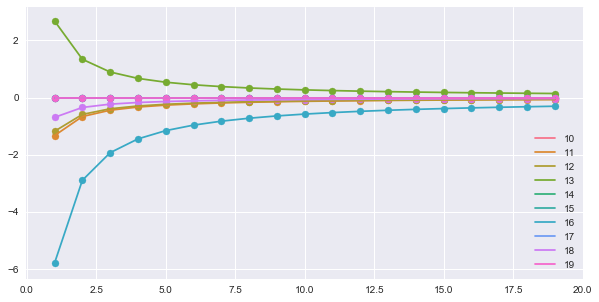

In [441]:
with sns.color_palette("husl", 10):
    for group in range(10, 20):
        name = 'n_solved'

        vardict[name]
        nx = 20
        x = np.arange(1, nx)
        y = np.zeros(nx-1)
        for v in vardict[name]:
            coef = df_coef[v + name][group]
            if v == "tanh_":
                y += np.tanh(x) * coef
            if v == "exp_":
                y += np.exp(x) * coef
            if v == "log_":
                y += np.log(x) * coef
            if v == "inv_":
                y += 1.0/x * coef
            if v == "":
                y += x * coef

        y *= 532.75
        plt.plot(x, y)
        plt.scatter(x, y)
plt.legend(range(10, 20))

In [283]:
xmax

drdt                                            1
java                                            1
lowlevel                                        1
max_error_contest                               1
max_error_practice                              1
max_probability_contest                         1
max_probability_practice                        1
max_ratingdiff_contest                          1
max_ratingdiff_practice                         1
max_solvetime                                   1
max_timediff                                    1
max_wrong_contest                               1
max_wrong_practice                              1
mean_error_contest                              1
mean_error_practice                             1
mean_probability_contest                        1
mean_probability_practice                       1
mean_ratingdiff_contest                         1
mean_ratingdiff_practice                        1
mean_solvetime                                  1


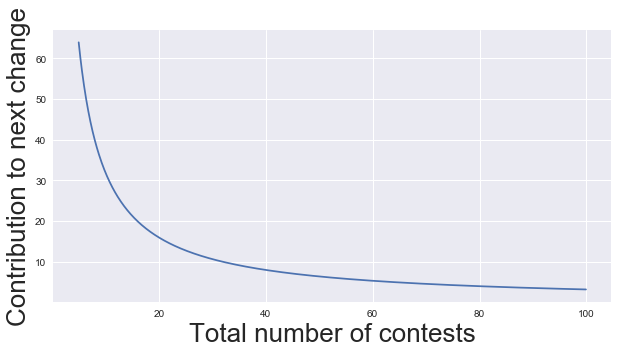

In [295]:
x = np.arange(5, 100, .1)
plt.plot(x, .6/x * 532.75)
plt.xlabel('Total number of contests', fontsize=26)
plt.ylabel('Contribution to next change', fontsize=26)